In [1]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
retail = pd.read_csv("../input/ecommerce-data/data.csv",encoding='cp874')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Checking the null values in the dataset

In [5]:
retail.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

In [6]:
pd.DataFrame(data = (retail.isna().sum() / retail.shape[0]) * 100, index = retail.columns, columns = ['% Null Values'])

,% Null Values
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


#### Around 25% of transactions do not have a CustomerID and 2.68% of transactions do not have a Description of product.

### Dropping the rows with null values in CustomerID column

In [7]:
retail.dropna(subset=['CustomerID'],how='any',inplace=True)
retail.shape

(406829, 8)

In [8]:
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Checking duplicate rows in the dataset

In [9]:
retail.duplicated().sum()

5225

In [10]:
retail.drop_duplicates(inplace=True)

In [11]:
retail.shape

(401604, 8)

### Removing the cancelled orders from the dataset

In [12]:
retail = retail[retail['Quantity'] > 0]

In [13]:
retail.shape

(392732, 8)

In [14]:
pd.DataFrame(data=[retail['InvoiceNo'].nunique(),retail['StockCode'].nunique(),retail['CustomerID'].nunique()],columns=['Count'],
                   index=['Number of Transactions','Number of Unique Products Bought','Number of Unique Customers'])

,Count
Number of Transactions,18536
Number of Unique Products Bought,3665
Number of Unique Customers,4339


# RFM Analysis
RFM (**Recency, Frequency, Monetary**) analysis is a customer segmentation technique that uses past purchase behaviour to divide customers into groups. <br> RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.
- RECENCY (R): Days since last purchase 
- FREQUENCY (F): Total number of purchases 
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

## Recency
To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase**.

In [15]:
retail['InvoiceDate'] = retail['InvoiceDate'].astype('datetime64')
retail['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [16]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [17]:
retail['Date'] = retail['InvoiceDate'].apply(lambda x: x.date())

In [18]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [19]:
recency_df = retail.groupby(by='CustomerID', as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [20]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


In [21]:
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


## Frequency
Frequency helps us to know **how many times a customer purchased from us**. To do that we need to check how many invoices are registered by the same customer.

In [22]:
temp = retail.copy()
temp.drop_duplicates(['InvoiceNo','CustomerID'],keep='first',inplace=True)
frequency_df = temp.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


## Monetary
Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total cost to have the total price per invoice.

In [23]:
retail['TotalCost'] = retail['Quantity'] * retail['UnitPrice']

In [24]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [25]:
monetary_df = retail.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


# Create RFM Table

In [26]:
rfm_df = recency_df.merge(frequency_df,on='CustomerID').merge(monetary_df,on='CustomerID')
rfm_df.set_index('CustomerID',inplace=True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


## Customer segments with RFM Model
Before moving to customer segments, Let's see the application of Pareto Principle – commonly referred to as the 80-20 rule on our dataset by applying it to our RFM variables.

Pareto’s rule says **80% of the results come from 20% of the causes**.

Similarly, **20% customers contribute to 80% of your total revenue**. Let's verify that because that will help us know which customers to focus on when marketing new products.

### Applying 80-20 rule

In [27]:
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  7109767.12


In [28]:
customers_ranked = rfm_df
customers_ranked['Rank'] = customers_ranked['Monetary'].rank(ascending=False)
customers_ranked.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,10.0
12347.0,2,7,4310.00,335.0
12348.0,75,4,1797.24,1004.0
12349.0,18,1,1757.55,1027.0
12350.0,310,1,334.40,3097.0


In [29]:
customers_ranked.sort_values(by='Rank',ascending=True,inplace=True)
customers_ranked.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
14646.0,1,74,280206.02,1.0
18102.0,0,60,259657.30,2.0
17450.0,8,46,194390.79,3.0
16446.0,0,2,168472.50,4.0
14911.0,1,201,143711.17,5.0


In [30]:
# Get top 20% of the customers
top_20_cutoff = 4339 * 20 /100
top_20_cutoff

867.8

In [31]:
# Sum the monetary values over the customer with rank <= 868
revenueByTop20 = customers_ranked[customers_ranked['Rank'] <= 868]['Monetary'].sum()
revenueByTop20

6637300.820999999

#### We observe that the revenue generated by 20% of the top customers is somewhat less than 80% of the total revenue. However, these two numbers are not exactly the same always but they are very close to each other in our case. So, it gave us a good indication of Pareto's rule holding true.

### Applying RFM Score Formula

The simplest way to create customers segments from RFM Model is to use **Quartiles**. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 5 * 5 * 5 possible combinations. So, we will use quartiles.

#### RFM Quartiles

In [32]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,306.455,1085.5
0.50,50.0,2.0,668.560,2170.0
0.75,141.5,5.0,1660.315,3254.5


In [33]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.5},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 306.45500000000004,
  0.5: 668.5600000000002,
  0.75: 1660.315000000001},
 'Rank': {0.25: 1085.5, 0.5: 2170.0, 0.75: 3254.5}}

### Creation of RFM segmentation table

We will create two segmentation conditions, one for recency and other for fequency and monetary. It's because high recency is bad, while high frequency and monetary value is good.

In [34]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [35]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [36]:
# Create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [37]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
14646.0,1,74,280206.02,1.0,4,4,4
18102.0,0,60,259657.30,2.0,4,4,4
17450.0,8,46,194390.79,3.0,4,4,4
16446.0,0,2,168472.50,4.0,4,2,4
14911.0,1,201,143711.17,5.0,4,4,4


Now that we have the score of each customer, we can represent our customer segmentation.<br>
First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [38]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
14646.0,1,74,280206.02,1.0,4,4,4,444
18102.0,0,60,259657.30,2.0,4,4,4,444
17450.0,8,46,194390.79,3.0,4,4,4,444
16446.0,0,2,168472.50,4.0,4,2,4,424
14911.0,1,201,143711.17,5.0,4,4,4,444


Best Recency score = 4: most recently purchased. <br>
Best Frequency score = 4: most quantity purchase. <br>
Best Monetary score = 4: spent the most.

Let's see who are our **Champions** (Top 10 customers).

In [39]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
14646.0,1,74,280206.02,1.0,4,4,4,444
18102.0,0,60,259657.30,2.0,4,4,4,444
17450.0,8,46,194390.79,3.0,4,4,4,444
14911.0,1,201,143711.17,5.0,4,4,4,444
14156.0,9,55,117210.08,7.0,4,4,4,444
17511.0,2,31,91062.38,8.0,4,4,4,444
16684.0,4,28,66653.56,11.0,4,4,4,444
14096.0,4,17,65164.79,12.0,4,4,4,444
13694.0,3,50,65039.62,13.0,4,4,4,444


**How many customers do we have in each segment?**

In [40]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Customers at risk of churning: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Almost Churned Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Churned Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  455
Loyal Customers:  872
Big Spenders:  1085
Customers at risk of churning:  70
Almost Churned Customers:  10
Churned Customers:  441


Now that we knew our customers segments we can choose how to target or deal with each segment.

For example:

**Best Customers - Champions**: Reward them. They can be early adopters to new products. Suggest them to share your products with their friends or family using "Referral Program" feature and when any of their referrals make their first purchase then they will also get some cashback or discount on products. It will help to increase conversion rates.

**Loyal Customers and Big Spenders**: Recommend your annual or quarterly membership program to them with additional benefits. By doing so, they will shop more frequently and for more amount.  

**Customers at the risk of churning**: Suggest your "Referral Program" and "Annual Membership Program" both to prevent these customers from churning as they were frequent and high spenders in the past. These should be focussed upon more.

**Almost Churned Customers**: Send them personalized emails and encourage them to shop. Along with that, recommend your top benefits program as they were also the best customers in the past.

**Churned Customers**: They probably bought once or very few times and they bought for very less amount. These should not be focussed more as they are already churned.

### Conclusion
To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.  

RFM model can be used in conjunction with certain predictive models like **K-means clustering**, **Logistic Regression** and **Recommendation Engines** to produce better informative results on customer behavior.

We will go for K-means since it has been widely used for Market Segmentation and it offers the advantage of being simple to implement.

In [41]:
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,1,74,280206.02
18102.0,0,60,259657.30
17450.0,8,46,194390.79
16446.0,0,2,168472.50
14911.0,1,201,143711.17


In [42]:
features = rfm_data.columns

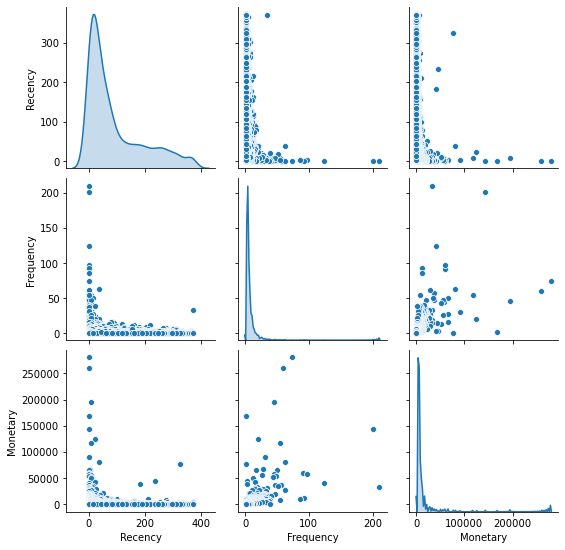

In [43]:
sns.pairplot(rfm_data,diag_kind='kde')

### *Inferences:*
- All the features are highly right skewed.

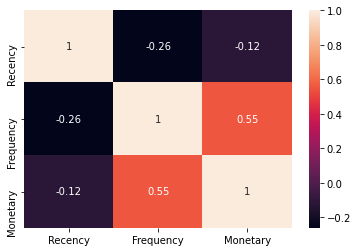

In [44]:
sns.heatmap(rfm_data.corr(),annot=True)

### *Inferences:*
- There is some decent positive correlation between Monetary and Frequency features.

### We will apply Power Transformation to convert these features into a normal distribution.

In [45]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
rfm_data = pd.DataFrame(pt.fit_transform(rfm_data))
rfm_data.columns = features
rfm_data.head()

,Recency,Frequency,Monetary
0,-1.928590,2.228021,3.878920
1,-2.225967,2.189298,3.840045
2,-1.159197,2.130843,3.690216
3,-2.225967,-0.195479,3.614932
4,-1.928590,2.348232,3.530336


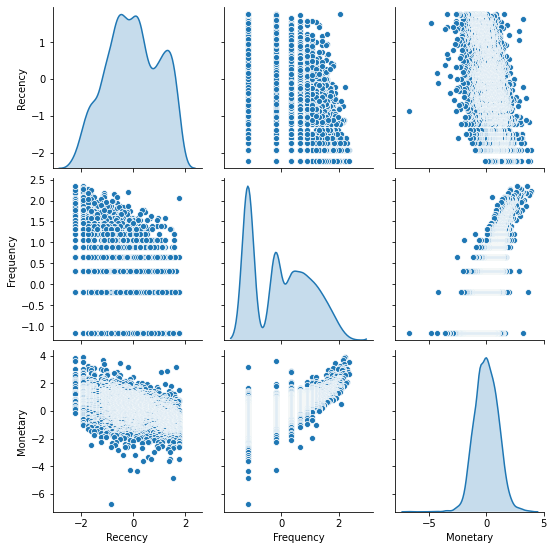

In [46]:
sns.pairplot(rfm_data,diag_kind='kde')

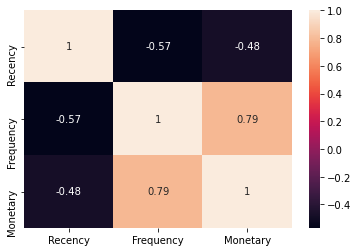

In [47]:
sns.heatmap(rfm_data.corr(),annot=True)

### *Inferences:*
- There is high positive correlation between Frequency and Monetary features after applying Power transformation.

# PCA

Applying PCA to reduce the the dimensions and the correlation between Frequency and Monetary features.

In [48]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
rfm_scaled = sc.fit_transform(rfm_data)
rfm_scaled[:5]

array([[-1.9285897 ,  2.22802133,  3.87892027],
       [-2.22596699,  2.18929829,  3.84004469],
       [-1.15919715,  2.13084345,  3.69021556],
       [-2.22596699, -0.19547892,  3.61493156],
       [-1.9285897 ,  2.34823212,  3.53033635]])

In [49]:
from sklearn.decomposition import PCA

pca = PCA()
pca_transformed_data = pca.fit_transform(rfm_scaled)

In [50]:
pca.explained_variance_

array([2.23289424, 0.56318573, 0.2046116 ])

In [51]:
var_exp = pca.explained_variance_ratio_
var_exp

array([0.74412654, 0.18768531, 0.06818815])

In [52]:
pca.components_

array([[-0.51572301,  0.61720666,  0.59421016],
       [-0.84520666, -0.25302607, -0.47074783],
       [ 0.14019803,  0.74500587, -0.65215854]])

In [53]:
np.cumsum(var_exp)

array([0.74412654, 0.93181185, 1.        ])

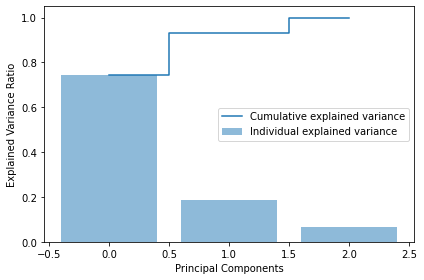

In [54]:
plt.figure(figsize=(6,4))
plt.bar(range(3), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(3), np.cumsum(var_exp), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [55]:
X = rfm_scaled.copy()
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X)

In [56]:
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1
0,4.674662,-0.759684
1,4.781025,-0.480240
2,4.105759,-1.296559
3,3.175361,0.229142
4,4.541724,-0.626005


# K-Means Clustering

In [57]:
X = df_pca.copy()

In [58]:
from sklearn.cluster import KMeans

cluster_range = range(1, 15)
cluster_errors = []
cluster_sil_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia

# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame({ "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,12129.394896
1,2,5307.384656
2,3,3876.589063
3,4,2897.823686
4,5,2321.796188
5,6,1917.120455
6,7,1692.956638
7,8,1528.882883
8,9,1381.248280
9,10,1252.666824


Text(0, 0.5, 'Cluster Errors')

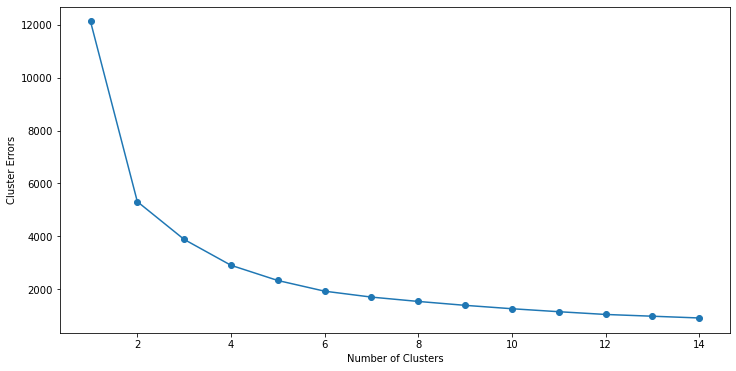

In [59]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot(clusters_df['num_clusters'], clusters_df['cluster_errors'], marker = "o" )
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Errors')

In [60]:
for k in range(2,16):
    cluster = KMeans(n_clusters=k, random_state=0)
    labels = cluster.fit_predict(df_pca)
    
    sil_avg = silhouette_score(df_pca, labels)
    print('For',k,'clusters, average silhoutte score =',sil_avg)

For 2 clusters, average silhoutte score = 0.4657521912116465
For 3 clusters, average silhoutte score = 0.36528600223035507
For 4 clusters, average silhoutte score = 0.3810624057237336
For 5 clusters, average silhoutte score = 0.37885476437960264
For 6 clusters, average silhoutte score = 0.3789977781232463
For 7 clusters, average silhoutte score = 0.36838717235890767
For 8 clusters, average silhoutte score = 0.3596816233435805
For 9 clusters, average silhoutte score = 0.3520849054817613
For 10 clusters, average silhoutte score = 0.35638144252576265
For 11 clusters, average silhoutte score = 0.35402602531281674
For 12 clusters, average silhoutte score = 0.34189243538147357
For 13 clusters, average silhoutte score = 0.3407237427268755
For 14 clusters, average silhoutte score = 0.3440129900053086
For 15 clusters, average silhoutte score = 0.33872154807520083


### *Inferences:*
- We observe from the elbow plot a sharp bend after the number of clusters increase by 2.
- Silhoutte Score is also the highest for 2 clusters.
- But, there is also a significant reduce in cluster error as number of clusters increase from 2 to 4 and after 4, the reduction is not much.
- So, we will choose n_clusters = 4 to properly segment our customers.

In [61]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(df_pca)
labels = kmeans.predict(df_pca)
centroids = kmeans.cluster_centers_

print('Centroid Values:')
print(centroids)

Centroid Values:
[[ 1.96526946  0.08277195]
 [-1.75929346 -0.37762366]
 [ 0.29298493 -0.42078166]
 [-0.69733759  0.90323872]]


In [62]:
# creating new column in df_pca dataframe for cluster number  
df_pca['Cluster'] = labels
df_pca.head()

,0,1,Cluster
0,4.674662,-0.759684,0
1,4.781025,-0.480240,0
2,4.105759,-1.296559,0
3,3.175361,0.229142,0
4,4.541724,-0.626005,0


In [63]:
df_pca['Cluster'].value_counts()

2    1243
0    1095
1    1071
3     930
Name: Cluster, dtype: int64

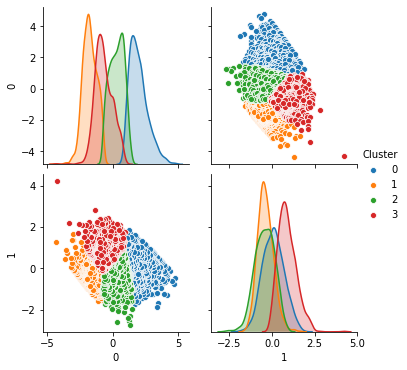

In [64]:
sns.pairplot(df_pca,diag_kind='kde',hue='Cluster')

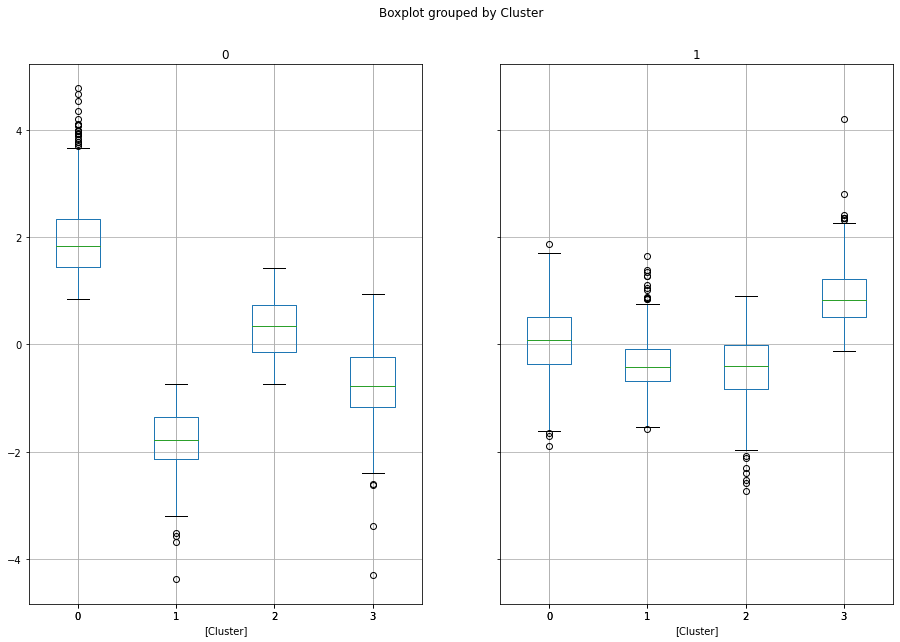

In [65]:
df_pca.boxplot(by='Cluster', figsize=(15, 10))
plt.show()

In [66]:
customers_grouped = pd.DataFrame(pt.inverse_transform(rfm_data),columns=rfm_data.columns,index=rfm_df.index)
customers_grouped['Cluster'] = df_pca['Cluster'].values
customers_grouped['RFMScore'] = rfm_segmentation['RFMScore'].values
customers_grouped.head()

,Recency,Frequency,Monetary,Cluster,RFMScore
CustomerID,,,,,
14646.0,1.0,74.0,280206.02,0,444
18102.0,0.0,60.0,259657.30,0,444
17450.0,8.0,46.0,194390.79,0,444
16446.0,0.0,2.0,168472.50,0,424
14911.0,1.0,201.0,143711.17,0,444


In [67]:
top_spenders_and_loyal_customers = customers_grouped[(customers_grouped['RFMScore'] == '444') | (customers_grouped['RFMScore'] == '443') | (customers_grouped['RFMScore'] == '434')]
top_spenders_and_loyal_customers

,Recency,Frequency,Monetary,Cluster,RFMScore
CustomerID,,,,,
14646.0,1.0,74.0,280206.02,0,444
18102.0,0.0,60.0,259657.30,0,444
17450.0,8.0,46.0,194390.79,0,444
14911.0,1.0,201.0,143711.17,0,444
14156.0,9.0,55.0,117210.08,0,444
...,...,...,...,...,...
17323.0,15.0,7.0,906.52,0,443
13991.0,12.0,6.0,852.88,0,443
16877.0,12.0,6.0,846.62,0,443


In [68]:
customers_churned = customers_grouped[(customers_grouped['RFMScore'] == '111') | (customers_grouped['RFMScore'] == '112') | (customers_grouped['RFMScore'] == '121')]
customers_churned

,Recency,Frequency,Monetary,Cluster,RFMScore
CustomerID,,,,,
14603.0,274.0,1.0,660.00,1,112
17046.0,157.0,1.0,642.02,1,112
14000.0,211.0,1.0,635.66,1,112
14036.0,284.0,1.0,626.65,1,112
15147.0,240.0,1.0,623.50,1,112
...,...,...,...,...,...
17102.0,261.0,1.0,25.50,1,111
17763.0,263.0,1.0,15.00,1,111
15823.0,372.0,1.0,15.00,1,111


In [69]:
customers_at_risk_of_churning = customers_grouped[(customers_grouped['RFMScore'] == '144') | (customers_grouped['RFMScore'] == '143') | (customers_grouped['RFMScore'] == '134') | (customers_grouped['RFMScore'] == '133') | (customers_grouped['RFMScore'] == '142') | (customers_grouped['RFMScore'] == '124')]
customers_at_risk_of_churning

,Recency,Frequency,Monetary,Cluster,RFMScore
CustomerID,,,,,
15749.0,235.0,3.0,44534.30,2,134
15098.0,182.0,3.0,39916.50,2,134
12590.0,211.0,2.0,9864.26,2,124
13093.0,275.0,8.0,7832.47,2,144
12980.0,157.0,9.0,7374.90,2,144
...,...,...,...,...,...
17341.0,156.0,3.0,682.29,2,133
15574.0,177.0,4.0,675.64,2,133
13951.0,176.0,3.0,674.45,2,133


In [70]:
new_customers_or_avg_spenders = customers_grouped[(customers_grouped['RFMScore'] == '422') | (customers_grouped['RFMScore'] == '411') | (customers_grouped['RFMScore'] == '412') | (customers_grouped['RFMScore'] == '421') | (customers_grouped['RFMScore'] == '413') | (customers_grouped['RFMScore'] == '431')]
new_customers_or_avg_spenders

,Recency,Frequency,Monetary,Cluster,RFMScore
CustomerID,,,,,
16800.0,11.0,1.0,1162.65,3,413
17727.0,15.0,1.0,1060.25,3,413
12713.0,0.0,1.0,848.55,3,413
14756.0,15.0,1.0,738.96,3,413
12478.0,3.0,1.0,680.99,3,413
...,...,...,...,...,...
14865.0,7.0,2.0,52.20,3,421
18184.0,15.0,1.0,49.80,3,411
15992.0,3.0,1.0,41.99,3,411


#### Inferences:
- **Loyal Customers and Big Spenders**: Reward them. They can be early adopters to new products. Suggest them to share your products with their friends or family using "Referral Program" feature and when any of their referrals make their first purchase then they will also get some cashback or discount on products. It will help to increase conversion rates. Recommend your annual or quarterly membership program to them with additional benefits. By doing so, they will shop more frequently and for more amount.

- **Customers Churned**: They probably bought once or very few times and they bought for very less amount. These should not be focussed more as they are already churned.

- **Customers at the risk of churning**: Suggest your "Referral Program" and "Annual Membership Program" both to prevent these customers from churning as they were frequent and high spenders in the past. These should be focussed upon the most to avoid churning.

- **New customers or Average Spenders**: Customers in this category are either new customers who shopped recently but they didn't spend much or the customers who shop frequently but spend very less amount. These customers should also be focussed more as they can turn out to be the best customers in the future by giving them relevant offers and discounts so that they will shop for more and more.

# Modelling

## Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve

In [72]:
y = df_pca['Cluster']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.3, random_state=42, stratify=y)

In [74]:
lr = LogisticRegression(max_iter=1000,random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [75]:
y_test_predicted = lr.predict(X_test)
y_train_predicted = lr.predict(X_train)

In [76]:
accuracy_train = accuracy_score(y_train, y_train_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)
print('Train Set Accuracy for Power Transformed Data:',round(accuracy_train*100,2),'%')
print('Test Set Accuracy for Power Transformed Data:',round(accuracy_test*100,2),'%')

Train Set Accuracy for Power Transformed Data: 100.0 %
Test Set Accuracy for Power Transformed Data: 100.0 %


In [77]:
kf= KFold(shuffle=True, n_splits=5, random_state=0)
score = cross_val_score(lr, df_pca, y, cv=kf, scoring='f1_weighted')
print('Bias Error:',1-np.mean(score))
print('Variance Error:',np.std(score,ddof=1))

Bias Error: 0.0
Variance Error: 0.0


In [78]:
cm = confusion_matrix(y_test, y_test_predicted)
print(cm)

[[329   0   0   0]
 [  0 321   0   0]
 [  0   0 373   0]
 [  0   0   0 279]]


- #### Precision = TruePositives / (TruePositives + FalsePositives)

- #### Recall = TruePositives / (TruePositives + FalseNegatives)

In [79]:
print(classification_report(y_test,y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       321
           2       1.00      1.00      1.00       373
           3       1.00      1.00      1.00       279

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



## Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB

In [81]:
nb = GaussianNB()
score = cross_val_score(nb, df_pca, y, cv=kf, scoring='f1_weighted')
print('Bias Error:',1-np.mean(score))
print('Variance Error:',np.std(score,ddof=1))

Bias Error: 0.0
Variance Error: 0.0


In [82]:
nb.fit(X_train,y_train)

GaussianNB()

In [83]:
y_train_predicted = nb.predict(X_train)
y_test_predicted = nb.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)

print('Train Set Accuracy for Power Transformed Data:',round(accuracy_train*100,2),'%')
print('Test Set Accuracy for Power Transformed Data:',round(accuracy_test*100,2),'%')

Train Set Accuracy for Power Transformed Data: 100.0 %
Test Set Accuracy for Power Transformed Data: 100.0 %


In [84]:
print(confusion_matrix(y_test, y_test_predicted))

[[329   0   0   0]
 [  0 321   0   0]
 [  0   0 373   0]
 [  0   0   0 279]]


In [85]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       321
           2       1.00      1.00      1.00       373
           3       1.00      1.00      1.00       279

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



# Conclusion
We saw that using classification models like Logisitc Regression and Naive Bayes, we predicted the clusters for customers using RFM dataset as independent variables and Cluster as the target variable. The clusters predicted by the classification models perfectly aligns with K-Means clustering. So, we can conclude that our clusters are correct.